In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

56


In [2]:
data_noise = 0.00
plotlim = [-3, 3]
subfolder = 'traj_repr'

from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('repr', batch_size = 3000, noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector')

datatype not supported


TypeError: 'NoneType' object is not iterable

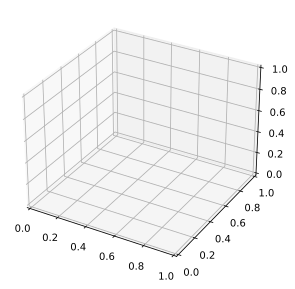

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for X_viz, y_viz in dataloader:
    #print(X_viz, y_viz)
    
    x = X_viz[0:50].numpy()
    y = y_viz[0:50].numpy()
    ax.scatter(x[:,0],x[:,1],x[:,2], marker = '*')
    ax.scatter(y[:,0],y[:,1],y[:,2], marker='^')
    plt.show()
    break

In [ ]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 3, 3 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 1
# num_steps = 1 is autonomous dynamics
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

# non_linearity = 'tanh' #'relu' #
# architecture = 'inside' #outside

non_linearity='tanh'
architecture='inside'

In [ ]:
num_epochs = 80 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, output_dim=data_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


In [ ]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)

In [ ]:
w = anode.linear_layer.weight
b = anode.linear_layer.bias
dt = anode.T/anode.time_steps   #here was no -1 before which does not fit with adjoint solver otherwise
k = int(T/dt)
#print(k)
w_t = anode.flow.dynamics.fc2_time[0].weight
b_t = anode.flow.dynamics.fc2_time[0].bias
print(w)
print(b)
print(anode.flow.dynamics.fc2_time)

In [13]:
x = np.array([3,0.2])

S = 0.25
n = 5
k21 = 1
k12 = 1
A = np.array([[0, k21], [k12, 0]])

Ax = np.matmul(A,x)
act_x = S**n/(S**n + Ax**n)

[0.33333333 5.        ]


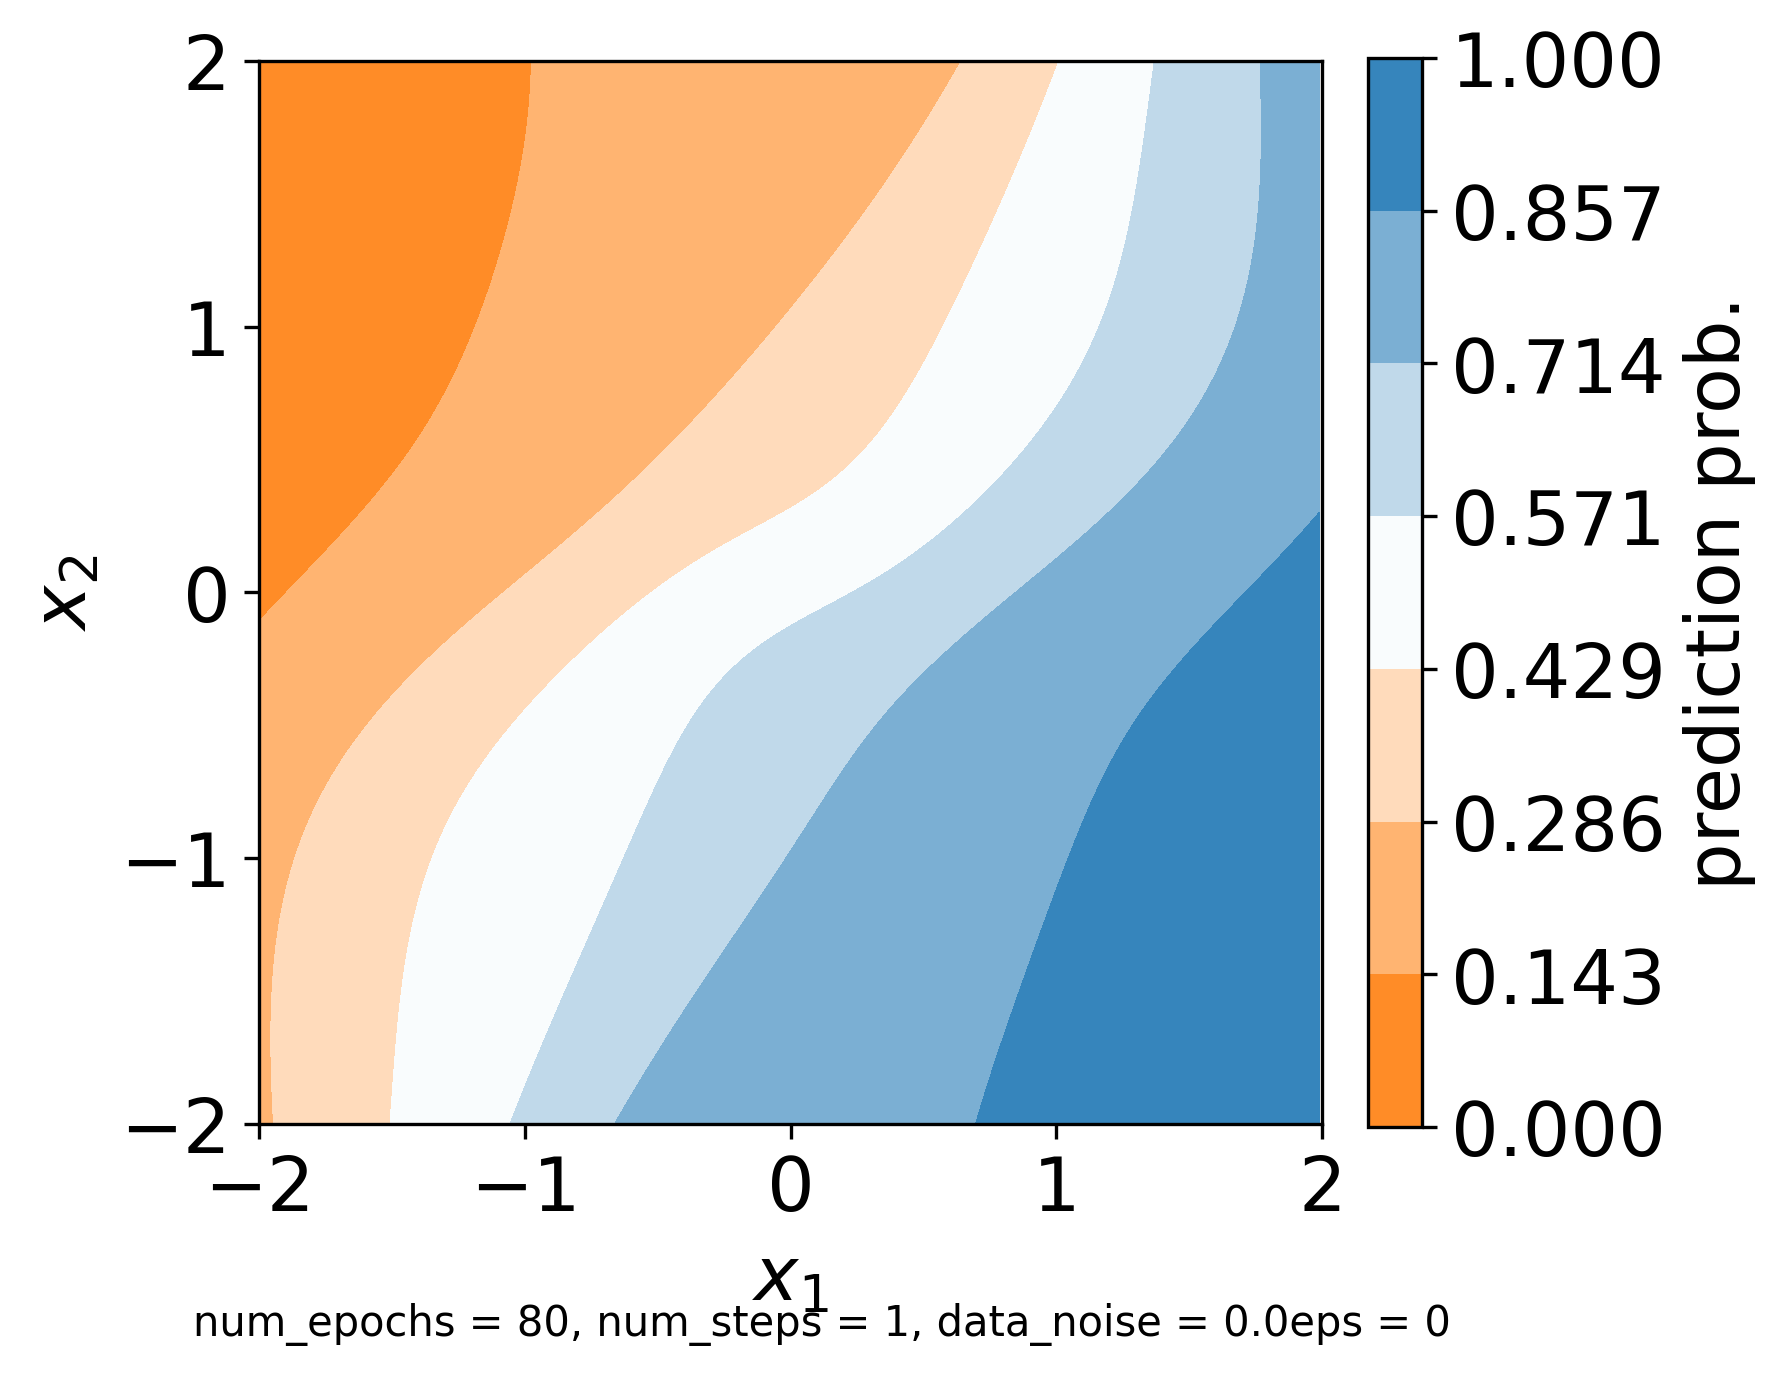

In [10]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'
        
fig_name_base = os.path.join(subfolder, 'levelsets_TS')
classification_levelsets(anode, fig_name_base, footnote = footnote + 'eps = 0')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)

display(img1)

In [9]:
from plots.gifs import trajectory_gif
from IPython.display import Image

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory_TS.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory_TS.gif")
display(traj)

ValueError: The number of derivatives at boundaries does not match: expected 3, got 0+0

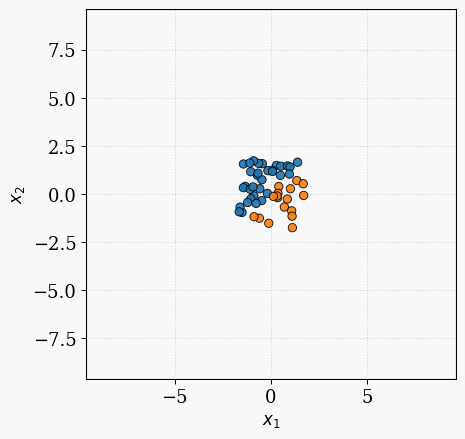

In [9]:
traj = Image(filename="trajectory_TS.gif")
display(traj)